In [6]:
import pandas as pd
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/processed/user_experiment_data_clean.csv')

# Load pre-trained sentiment model (downloads automatically first time — ~200MB)
print("Loading sentiment model... (first time takes ~2 mins)")
sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True,
    max_length=512
)

# Run sentiment on a sample first (full 50K takes long — use 5K for the project)
sample_df = df.sample(5000, random_state=42)
print("Running sentiment analysis on 5,000 captions...")

results = sentiment_pipe(sample_df['post_caption'].tolist(), batch_size=64)
sample_df['sentiment'] = [r['label'] for r in results]
sample_df['sentiment_score'] = [r['score'] for r in results]

print("\nSentiment distribution:")
print(sample_df['sentiment'].value_counts())
print(f"\nPositive rate: {(sample_df['sentiment']=='POSITIVE').mean():.1%}")

Loading sentiment model... (first time takes ~2 mins)
Running sentiment analysis on 5,000 captions...

Sentiment distribution:
sentiment
NEGATIVE    3280
POSITIVE    1720
Name: count, dtype: int64

Positive rate: 34.4%


Positive sentiment rate by group:
sentiment  pct_positive
group                  
control           0.386
treatment         0.300


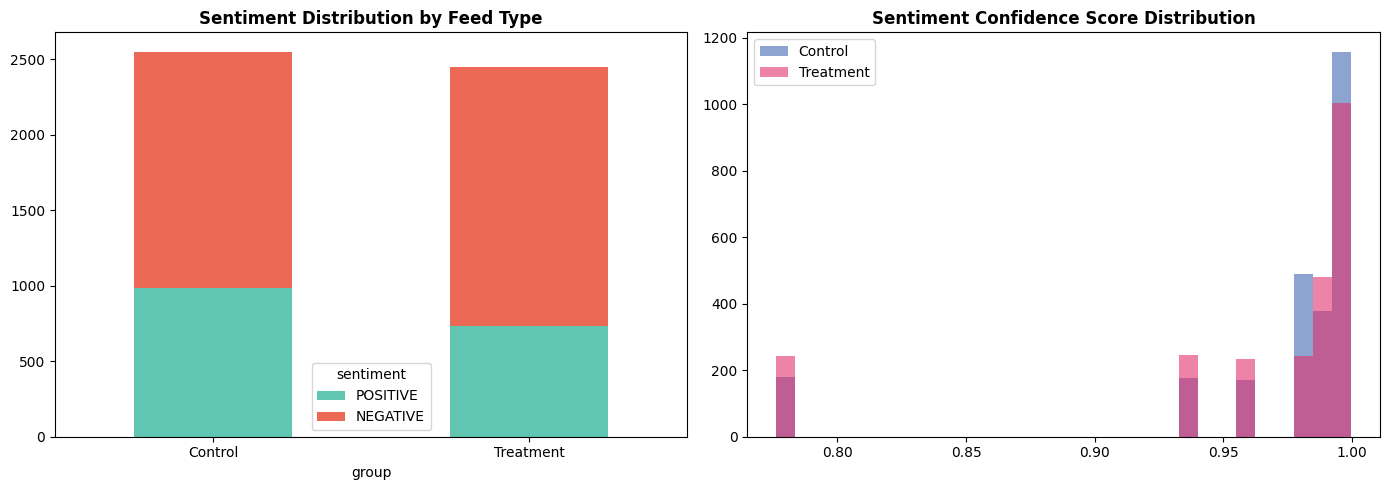

In [7]:
# Does the AI feed surface more positive content?
sentiment_by_group = sample_df.groupby(['group', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_group['pct_positive'] = sentiment_by_group['POSITIVE'] / sentiment_by_group.sum(axis=1)

print("Positive sentiment rate by group:")
print(sentiment_by_group[['pct_positive']].round(3))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar
sentiment_by_group[['POSITIVE', 'NEGATIVE']].plot(
    kind='bar', stacked=True, ax=axes[0],
    color=['#44BBA4', '#E94F37'], alpha=0.85
)
axes[0].set_title('Sentiment Distribution by Feed Type', fontweight='bold')
axes[0].set_xticklabels(['Control', 'Treatment'], rotation=0)

# Sentiment score distribution
for group, color in [('control', '#4267B2'), ('treatment', '#E1306C')]:
    subset = sample_df[sample_df.group == group]['sentiment_score']
    axes[1].hist(subset, bins=30, alpha=0.6, color=color, label=group.capitalize())
axes[1].set_title('Sentiment Confidence Score Distribution', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/nlp_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Use a small/fast embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model, min_topic_size=30, verbose=True)

# Fit on captions
captions = sample_df['post_caption'].tolist()
topics, probs = topic_model.fit_transform(captions)
sample_df['topic'] = topics

# View top topics
print("=== TOP 10 TOPICS ===")
topic_info = topic_model.get_topic_info().head(11)  # First row is usually "outliers" (-1)
print(topic_info[['Topic', 'Count', 'Name']].to_string())

# Save topic info
topic_info.to_csv('../data/processed/topic_info.csv', index=False)

2026-02-28 14:14:44,547 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2026-02-28 14:14:47,714 - BERTopic - Embedding - Completed ✓
2026-02-28 14:14:47,714 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-28 14:14:50,971 - BERTopic - Dimensionality - Completed ✓
2026-02-28 14:14:50,973 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-28 14:14:51,061 - BERTopic - Cluster - Completed ✓
2026-02-28 14:14:51,063 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-02-28 14:14:51,101 - BERTopic - Representation - Completed ✓


=== TOP 10 TOPICS ===
    Topic  Count                                     Name
0      -1    104      -1_honesty_journey_bad_mentalhealth
1       0    427      0_sunsets_goldenhour_energy_chasing
2       1    138                 1_wake_view_worth_nature
3       2    138            2_showing_reallife_looks_like
4       3     79  3_scratch_obsessed_honestly_homecooking
5       4     76                    4_spot_place_new_just
6       5     74               5_tip_shortcut_saves_quick
7       6     70                    6_spot_place_new_just
8       7     66         7_wellness_sunday_selfcare_reset
9       8     65  8_scratch_obsessed_honestly_homecooking
10      9     64  9_only_morningroutine_morning_lifestyle


In [10]:
import anthropic
from dotenv import load_dotenv
import os

load_dotenv()

client = anthropic.Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

# Prepare topic data as text for Claude to summarize
top_topics_str = topic_model.get_topic_info().head(10).to_string()
top_words_per_topic = {
    i: topic_model.get_topic(i) 
    for i in topic_model.get_topic_info()['Topic'].head(10).tolist()
    if i != -1
}
topic_keywords = "\n".join([
    f"Topic {tid}: {[w for w, _ in words[:5]]}" 
    for tid, words in top_words_per_topic.items()
])

prompt = f"""
You are a product analytics assistant at a social media company.
Based on these content topics detected from 5,000 user posts, write a concise 
weekly trend summary for the product team. Focus on 3-5 key insights and 
what they mean for product decisions.

Top content topics and their keywords:
{topic_keywords}

Context: These are from an AI-curated feed experiment. Treatment group users 
see AI-recommended content. Control group sees chronological feed.

Write a clear, actionable summary (150 words max) for a product manager.
"""

response = client.messages.create(
    model="claude-sonnet-4-20250514",
    max_tokens=400,
    messages=[{"role": "user", "content": prompt}]
)

trend_summary = response.content[0].text
print("=== AI-GENERATED TREND SUMMARY ===")
print(trend_summary)

# Save it
with open('../reports/weekly_trend_summary.txt', 'w') as f:
    f.write(trend_summary)

=== AI-GENERATED TREND SUMMARY ===
**Weekly Trend Summary - AI Feed Experiment**

**Key Insights:**

1. **Lifestyle content dominates** - Users heavily engage with wellness (Topic 7), home cooking (Topics 3,8), and nature photography (Topics 0,1). This suggests our AI algorithm successfully identifies high-engagement lifestyle verticals.

2. **Authenticity preference** - Topic 2's "reallife" emphasis indicates users value genuine, unfiltered content over polished posts. Consider boosting authentic content in AI recommendations.

3. **Productivity content emerging** - Topic 5 shows growing interest in life hacks and shortcuts, representing an underserved niche worth expanding.

4. **Food discovery trending** - Duplicate topics (4,6) around food exploration suggest strong user appetite for culinary content and local discovery features.

**Product Recommendations:**
- Enhance AI model to prioritize authentic lifestyle content
- Develop dedicated productivity content vertical
- Consider lo

Generating word clouds for 6 topics...
Topic IDs: [0, 1, 2, 3, 4, 5]


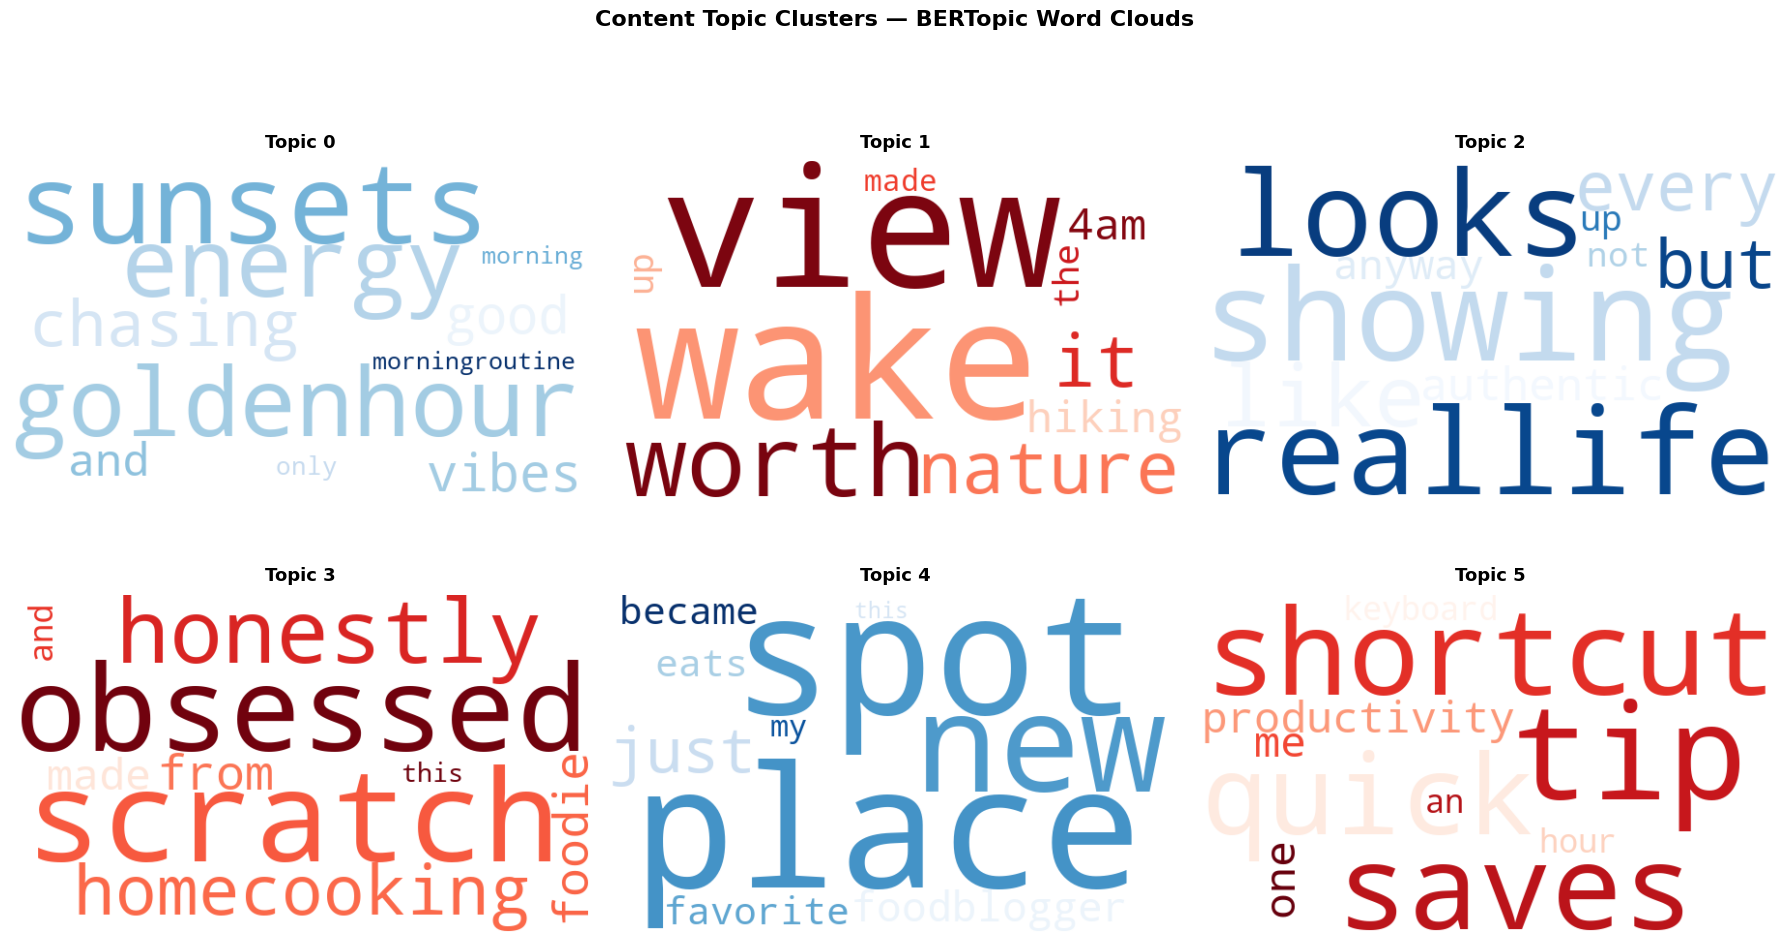

✅ Word clouds saved to reports/


In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

# Get top 6 topics (excluding -1 which is the outlier topic in BERTopic)
topic_info_clean = topic_model.get_topic_info()
topic_info_clean = topic_info_clean[topic_info_clean['Topic'] != -1].head(6)
top_topic_ids = topic_info_clean['Topic'].tolist()

print(f"Generating word clouds for {len(top_topic_ids)} topics...")
print(f"Topic IDs: {top_topic_ids}")

# Create a 2x3 grid of word clouds
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors = ['#4267B2', '#E1306C', '#44BBA4', '#F18F01', '#C73E1D', '#3B1F2B']

for idx, topic_id in enumerate(top_topic_ids):
    # Get words and their scores for this topic
    topic_words = topic_model.get_topic(topic_id)
    
    if not topic_words:
        axes[idx].text(0.5, 0.5, f'Topic {topic_id}\n(No words found)',
                      ha='center', va='center', transform=axes[idx].transAxes)
        continue
    
    # Convert to dict {word: score} for WordCloud
    word_freq = {word: max(score, 0.001) for word, score in topic_words}
    
    # Generate word cloud
    wc = WordCloud(
        width=600,
        height=350,
        background_color='white',
        colormap='Blues' if idx % 2 == 0 else 'Reds',
        max_words=30,
        prefer_horizontal=0.9,
        min_font_size=10
    )
    wc.generate_from_frequencies(word_freq)
    
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].set_title(f'Topic {topic_id}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].axis('off')

plt.suptitle('Content Topic Clusters — BERTopic Word Clouds',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/topic_wordclouds.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Word clouds saved to reports/")

In [12]:
# More interesting: compare WHICH topics appear more in each feed group
print("=== TOPIC DISTRIBUTION BY FEED GROUP ===\n")

# Add topic assignments back to sample_df
sample_df['topic'] = topics[:len(sample_df)]

# Count topic frequency per group
topic_by_group = sample_df.groupby(['group', 'topic']).size().unstack(fill_value=0)

# Calculate % share of each topic per group
topic_pct = topic_by_group.div(topic_by_group.sum(axis=1), axis=0) * 100

# Focus on top topics only
top_topics_display = [t for t in top_topic_ids if t in topic_pct.columns]

print(f"{'Topic':<10} {'Control %':>12} {'Treatment %':>14} {'Difference':>12} {'More in':>12}")
print("-" * 62)
for topic_id in top_topics_display:
    if topic_id in topic_pct.columns:
        ctrl_pct = topic_pct.loc['control', topic_id] if 'control' in topic_pct.index else 0
        trt_pct = topic_pct.loc['treatment', topic_id] if 'treatment' in topic_pct.index else 0
        diff = trt_pct - ctrl_pct
        more_in = "Treatment ↑" if diff > 0 else "Control ↑"
        words = [w for w, _ in topic_model.get_topic(topic_id)[:3]]
        print(f"Topic {topic_id:<4} {ctrl_pct:>12.1f}% {trt_pct:>13.1f}% {diff:>+11.1f}% {more_in:>12}")
        print(f"  Keywords: {', '.join(words)}")
        print()

=== TOPIC DISTRIBUTION BY FEED GROUP ===

Topic         Control %    Treatment %   Difference      More in
--------------------------------------------------------------
Topic 0             6.5%          10.7%        +4.2%  Treatment ↑
  Keywords: sunsets, goldenhour, energy

Topic 1             5.4%           0.0%        -5.4%    Control ↑
  Keywords: wake, view, worth

Topic 2             5.4%           0.0%        -5.4%    Control ↑
  Keywords: showing, reallife, looks

Topic 3             1.4%           1.8%        +0.3%  Treatment ↑
  Keywords: scratch, obsessed, honestly

Topic 4             1.3%           1.8%        +0.5%  Treatment ↑
  Keywords: spot, place, new

Topic 5             1.1%           1.8%        +0.7%  Treatment ↑
  Keywords: tip, shortcut, saves



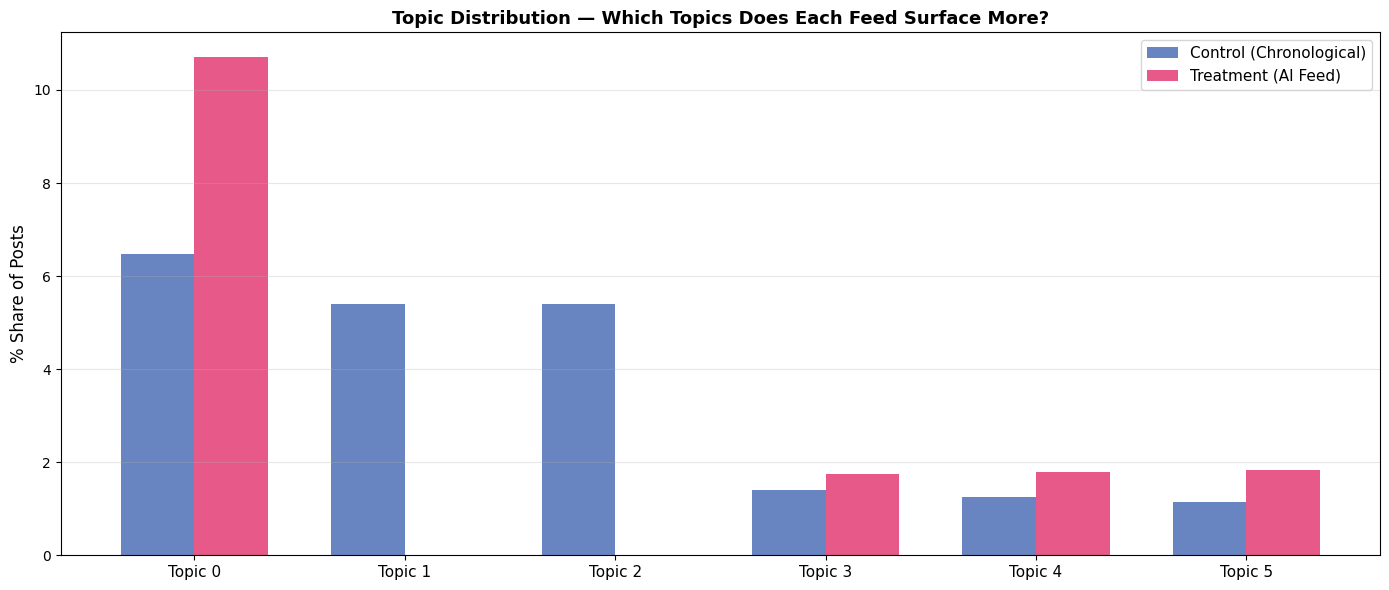

✅ Chart saved to reports/


In [13]:
fig, ax = plt.subplots(figsize=(14, 6))

topic_labels = [f"Topic {t}" for t in top_topics_display 
                if t in topic_pct.columns]
ctrl_vals = [topic_pct.loc['control', t] if 'control' in topic_pct.index else 0 
             for t in top_topics_display if t in topic_pct.columns]
trt_vals = [topic_pct.loc['treatment', t] if 'treatment' in topic_pct.index else 0 
            for t in top_topics_display if t in topic_pct.columns]

x = range(len(topic_labels))
width = 0.35

ax.bar([i - width/2 for i in x], ctrl_vals, width,
       label='Control (Chronological)', color='#4267B2', alpha=0.8)
ax.bar([i + width/2 for i in x], trt_vals, width,
       label='Treatment (AI Feed)', color='#E1306C', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(topic_labels, fontsize=11)
ax.set_ylabel('% Share of Posts', fontsize=12)
ax.set_title('Topic Distribution — Which Topics Does Each Feed Surface More?',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/topic_distribution_by_group.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved to reports/")